In [1]:
import optforge as of
import pysors
from optforge.benchmarks.vobench_benchmarks import VOBenchmark
import vobench as vb

sir_inputs = vb.imread(r"C:\Users\nkshv\Pictures\AA_AerofleetArt.jpg")
reg_inputs = vb.imread(r"F:\Stuff\Programming\AI\VOBench\VOBench\notebooks\affine\A2.jpeg")[:,:,0]
reg_targets = vb.imread(r"F:\Stuff\Programming\AI\VOBench\VOBench\notebooks\affine\A.jpeg")[:,:,0]
ds = vb.datasets.randsinlike_dataset()

class RHO:
    def __init__(self, p=2., c=0.0):
        self.p = p
        self.c = c
    def __call__(self, z):
        return self.c*z**self.p


In [2]:
BENCHMARKS = {
    "WasteTreatmentPlantDesign":
        {
            "bench": of.benchmarks.WasteTreatmentPlantDesign,
            "evals": 1000,
            "tol": None,
            "scale": 1/71e3,
            "n": 4
        },
    "ChemicalEquilibriumProblem":
        {
            "bench": of.benchmarks.ChemicalEquilibriumProblem,
            "evals": 1000,
            "tol": None,
            "scale": 1/5e20,
            "n": 4
        },
    "TransformerDesign":
        {
            "bench": of.benchmarks.TransformerDesign,
            "evals": 1000,
            "tol": None,
            "scale": 1/135,
            "n": 4
        },
    "BoxPacking1":
        {
            "bench": lambda: VOBenchmark(vb.BoxPacking.from_container(vb.CONTAINER1)),
            "evals": 1000,
            "tol": 1e-2,
            "scale": 1,
            "n": 4,
        },
    # "RectangleImageRecreation10":
    #     {
    #         "bench": lambda: VOBenchmark(vb.RectangleImageRecreation(sir_inputs, 10, learnable_bg = False)),
    #         "evals": 1000,
    #         "tol": None,
    #         "scale": 1,
    #         "n": 1,
    #     },
    # "Coregistration":
    #     {
    #         "bench": lambda: VOBenchmark(vb.Coregistration(reg_inputs, reg_targets, )),
    #         "evals": 1000,
    #         "tol": 1e-2,
    #         "scale": 1,
    #         "n": 1
    #     },
    # "Deformation":
    #     {
    #         "bench": lambda: VOBenchmark(vb.Deformation(reg_inputs, reg_targets, shape=(5,5))),
    #         "evals": 1000,
    #         "tol": 1e-2,
    #         "scale": 1,
    #         "n": 1
    #     },
    "LinearRegression":
        {
            "bench": lambda: VOBenchmark(vb.LinearRegression(ds),),
            "evals": 100,
            "tol": None,
            "scale": 1,
            "n": 4,
        },
    "PolynomialRegression":
        {
            "bench": lambda: VOBenchmark(vb.PolynomialRegression(ds, order=10),),
            "evals": 1000,
            "tol": None,
            "scale": 1,
            "n": 4,
        },
    "SinusoidalRegression":
        {
            "bench": lambda: VOBenchmark(vb.SinusoidalRegression(ds,),),
            "evals": 1000,
            "tol": None,
            "scale": 1,
            "n": 4,
        },
    "PiecewiseRegression":
        {
            "bench": lambda: VOBenchmark(vb.PiecewiseRegression(ds,),),
            "evals": 1000,
            "tol": None,
            "scale": 1,
            "n": 4,
        },
    "StepwiseRegression":
        {
            "bench": lambda: VOBenchmark(vb.StepwiseRegression(ds,),),
            "evals": 1000,
            "tol": None,
            "scale": 1,
            "n": 4,
        },
}

In [3]:
def make_optimizer(trial: of.Trial):
    return of.integrations.PySORSOptimizer(
        pysors.RSPI_FD(
            a_init = trial.suggest_float("a_init", 1e-8, 10, init=0.25),
            c_init = trial.suggest_float("c_init", 1e-8, 10, init=0.1, domain='log2'),
            beta = trial.suggest_float("beta", 1e-8, 10, init=0.5,),
            sigma_1 = trial.suggest_float("sigma_1", 1e-8, 10, init=0.25,),
            sigma_2 = trial.suggest_float("sigma_2", 1e-8, 10, init=0.101),
            distribution = trial.suggest_categorical("distribution", ['Uniform', 'Normal']),
            step_upd = trial.suggest_categorical("step_upd", ['half', 'inv', 'inv_sqrt']),
            theta = trial.suggest_float("theta", 1e-8, 10, init = 0.6),
            T_half = trial.suggest_int("T_half", 1, 1000, init = 10),
            T_power = trial.suggest_int("T_power", 1, 1000, init = 100),
        )
        )


def objective(trial: of.Trial):
    total = 1
    for k,v in BENCHMARKS.items():
        itotal = []
        for i in range(v['n']):
            bench:of.benchmarks.Benchmark = v["bench"]()
            #print(f'{k}-{i}')
            opt = make_optimizer(trial)
            try: bench.run(opt, v["evals"], tol=v['tol'], progress=False, print_results=False)
            except OverflowError: pass
            if len(bench.study.trials) == 0: vals = [float('inf')]
            vals = [float(t.objective_value.opt_value) for t in bench.study.trials]
            vals.sort() # type:ignore
            best = vals[0]
            trial.log(f'{k}_{i}', best)
            if v['tol'] is not None:
                best *= bench.study.current_eval / v['evals']
            itotal.append(best)

        best_total = sum(itotal) / len(itotal)
        trial.log(f'{k}_total', best_total)

        total *= (best_total * v['scale']) + 1
    #print(f'{total = }', '\n')
    return total


In [4]:
study = of.Study()
study.optimize(objective, 'optuna.tpe', max_evals = 1000, )

d:\miniconda3\envs\pytorch312\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


F:\Stuff\Programming\AI\pySORS\pySORS\src\pysors\rspi.py:107: RuntimeWarning: invalid value encountered in divide
  d2 = Hd/np.linalg.norm(Hd)


evals: 1000/1000 | best value: 110.6466                            
Job finished in 12344.0s., did 1000 evaluations.


In [5]:
study.best_trial.logs

{'WasteTreatmentPlantDesign_0': 172744.91483054982,
 'WasteTreatmentPlantDesign_1': 93314.77571279857,
 'WasteTreatmentPlantDesign_2': 168394.59632634663,
 'WasteTreatmentPlantDesign_3': 181383.91354845066,
 'WasteTreatmentPlantDesign_total': 153959.5501045364,
 'ChemicalEquilibriumProblem_0': 2.0268693833203158e+20,
 'ChemicalEquilibriumProblem_1': 1.2257557005754428e+21,
 'ChemicalEquilibriumProblem_2': 1.0252799317562011e+21,
 'ChemicalEquilibriumProblem_3': 1.174578876722133e+20,
 'ChemicalEquilibriumProblem_total': 6.427951145839722e+20,
 'TransformerDesign_0': 165.52705604182626,
 'TransformerDesign_1': 554.5297455791994,
 'TransformerDesign_2': 192.93595529295774,
 'TransformerDesign_3': 177.14366160960762,
 'TransformerDesign_total': 272.53410463089773,
 'BoxPacking1_0': 2.8669200590646606,
 'BoxPacking1_1': 1.90930845851162,
 'BoxPacking1_2': 1.925510846971661,
 'BoxPacking1_3': 1.9281973874955816,
 'BoxPacking1_total': 2.157484188010881,
 'LinearRegression_0': 0.0634512445257

In [6]:
study.best_params

{'a_init': 1.3916738990058146,
 'c_init': 0.8072387805967745,
 'beta': 5.033335921097635,
 'sigma_1': 0.24391634488641767,
 'sigma_2': 9.994086493906902,
 'distribution': 'Normal',
 'step_upd': 'half',
 'theta': 2.3706393959382197,
 'T_half': 633,
 'T_power': 1}

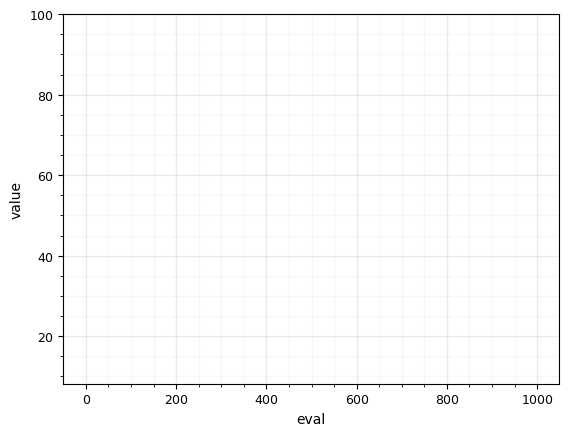

In [7]:
study.history.plot_convergence(ylim = (8.2, 100))